<a href="https://colab.research.google.com/github/klaragerlei/GoatsOfAllTime/blob/main/klara_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [22]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [23]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [24]:
#@title Data loading
import numpy as np
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [25]:
import pandas as pd
import numpy as np

!git clone https://github.com/klaragerlei/GoatsOfAllTime.git
import GoatsOfAllTime.data_loader as dl

data_to_analyze = dl.load_data(alldat, brain_area='MOp', feature='face')



fatal: destination path 'GoatsOfAllTime' already exists and is not an empty directory.
Loading data...


In [26]:
def change_bin_size(array_in, window_size=10):
  array_with_different_bins = np.add.reduceat(array_in, range(0, len(array_in), window_size))
  return array_with_different_bins

#test_array = np.array([0, 1, 0, 0, 1, 0,3, 4, 5, 4, 1, 2, 3, 4, 5, 5, 0])
#print(test_array.shape)
#array_out = change_bin_size(test_array, window_size=10)
#print(test_array)
#print(array_out)

In [27]:
def convert_data_to_bigger_bin_size_spikes(data_to_analyze):
  spikes_big_bins = []
  for session_id, session in data_to_analyze.iterrows():
    spikes_in_session = []
    spikes = session.spikes
    for neuron in range(spikes.shape[0]):
      spikes_from_neuron = []
      spikes_neuron = spikes[neuron]
      spikes_all_trials = np.array(spikes_neuron.reshape(-1))
      spikes_new_bin_size = change_bin_size(spikes_all_trials, window_size=10)
      spikes_in_session.append(spikes_new_bin_size)
    spikes_big_bins.append(spikes_in_session)
  data_to_analyze['spikes_bigger_bins'] = spikes_big_bins
  print(data_to_analyze.spikes_bigger_bins)
  return data_to_analyze

data_to_analyze = convert_data_to_bigger_bin_size_spikes(data_to_analyze)

10    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
20    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...
28    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: spikes_bigger_bins, dtype: object


In [28]:
def convert_data_to_bigger_bin_size_face(data_to_analyze):
  face_data = []
  for session_id, session in data_to_analyze.iterrows():
    face_in_session = session.face
    face_data_flat = face_in_session.reshape(-1)
    face_new_bin_size = change_bin_size(face_data_flat, window_size=10)
    face_data.append(face_new_bin_size)
  data_to_analyze['face_bigger_bins'] = face_data
  return data_to_analyze

data_to_analyze = convert_data_to_bigger_bin_size_face(data_to_analyze)

In [29]:
def add_number_of_spikes_per_neuron_to_df(df):
  number_of_spikes = []
  for recording_index, recording in df.iterrows():
    spikes_all = recording.spikes
    spikes_neuron = []
    for neuron in range(spikes_all.shape[0]):
      num_of_spikes = np.sum(spikes_all[neuron])
      spikes_neuron.append(num_of_spikes)
    number_of_spikes.append(spikes_neuron)
  df['number_of_spikes'] = number_of_spikes
  return df      

data_to_analyze = add_number_of_spikes_per_neuron_to_df(data_to_analyze)

In [30]:
# plot spikes across time
def plot_spikes_across_time():
  session_id = 0
  neuron_id = 10
  # spikes_of_neuron = data_to_analyze.spikes[session_id][neuron_id]

  session_to_analyze = data_to_analyze.spikes.iloc[session_id]
  number_of_spikes = data_to_analyze.number_of_spikes.iloc[session_id][neuron_id]
  print('Number of spikes: ' + str(number_of_spikes))
  spikes_of_neuron = session_to_analyze.reshape(session_to_analyze.shape[0], -1)[neuron_id]
  plt.figure()
  plt.plot(spikes_of_neuron)
  plt.show()
  plt.close()

In [31]:
# plot pupil size
def plot_pupil_size():
  print(data_to_analyze.iloc[session_id].pupil.shape)
  pupil_data_to_plot_1 = data_to_analyze.pupil.iloc[session_id][1].T[0]
  pupil_data_to_plot_2 = data_to_analyze.pupil.iloc[session_id][2].T[0]
  print(pupil_data_to_plot.shape)
  plt.figure()
  plt.plot(pupil_data_to_plot_1)
  plt.show()
  plt.close()
  plt.figure()
  plt.plot(pupil_data_to_plot_2)
  plt.show()
  plt.close()

In [32]:
def reshape_pupil_data():
  # Make input features for model
  session_id = 0   # we will analyze this session
  session_to_analyze = data_to_analyze.spikes.iloc[session_id]
  print('number of spikes')
  print(data_to_analyze.number_of_spikes.iloc[session_id])
  print('Number of neurons in this session: ' + str(session_to_analyze.shape[0]))
  # try only one trial
  trial_id = 2
  session_to_analyze_reshaped = session_to_analyze[:,trial_id,:] # first trial 
  pupil_data = data_to_analyze.pupil.iloc[0][0,trial_id]  # first trial 

  print(session_to_analyze_reshaped.shape)
  print(pupil_data.shape)




In [33]:
  def reshape_face_data(data_to_analyze, session_id=0, trial_id=None):
    # Make input features for model
    session_to_analyze = data_to_analyze.spikes.iloc[session_id]
    print('number of spikes')
    print(data_to_analyze.number_of_spikes.iloc[session_id])
    print('Number of neurons in this session: ' + str(session_to_analyze.shape[0]))

    session_to_analyze_reshaped = session_to_analyze[-1] # all trials 
    face_data = data_to_analyze.face.iloc[session_id][0,-1]  # all trials

    if trial_id != None:
      session_to_analyze_reshaped = session_to_analyze[:,trial_id,:] # one trial 
      face_data = data_to_analyze.face.iloc[session_id][0,trial_id]  # one trial 


    print(session_to_analyze_reshaped.shape)
    print(face_data.shape)
    return face_data, session_to_analyze_reshaped
behaviour_data, session_to_analyze_reshaped = reshape_face_data(data_to_analyze, trial_id=None)

number of spikes
[4, 1784, 391, 8565, 204, 34, 4777, 301, 64, 5462, 0, 3077, 50, 51, 509, 2135, 141, 64, 5977, 5520, 484, 1822, 9, 79, 0, 287, 556, 41, 100, 14010, 114, 148, 174, 113, 1307, 5292, 147, 1849, 403, 691, 251, 5487, 93, 48, 2263, 59, 76, 100, 10227, 119, 454, 1676, 14, 253, 127, 1110, 1678, 1570, 130, 1812, 200, 117, 126, 7273, 129, 5138, 80, 301, 321, 24, 3637, 21, 5651, 4862, 28, 50, 723, 836, 1071, 50, 5002, 713, 35, 0, 187, 185, 2214, 11, 241, 1630, 2840, 275, 729, 2881, 185, 599, 136, 745, 14723, 217, 11110, 730, 267, 72, 130, 1636, 3669, 140, 1892, 118, 107, 41, 76, 8279, 895, 966, 68, 234, 80, 5509, 287, 6506, 7983, 303, 35, 137, 51, 41, 1265, 143, 180, 309, 1643, 287, 21338, 28892, 16645, 13582, 5876, 15118, 15296, 6715, 4707, 8655, 7542, 6413, 5596, 119, 10387, 5268, 2304, 1554, 1347, 3554, 9785, 140, 1719, 310, 23, 311, 607, 1657, 481, 17437, 1053, 43, 4900, 400, 1345, 6340, 44, 2809, 547, 440, 1845, 75, 1675, 2696, 1114, 321, 2708, 5707, 1953, 2710, 455, 873, 521

In [50]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Define network

In [51]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')  # change bidi later
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

Split data to training and test

In [ ]:
def split_data_to_training_and_test():
  pass

Prepare input

In [52]:
def split_across_trials(data_to_analyze, session_id=0):
  session_data = data_to_analyze.spikes.iloc[session_id]
  # todo x0 should be the spikes and x1 the behaviour
  split_point = int(session_data.shape[1] / 2)
  x0 = torch.from_numpy(session_data[:, split_point:, :]).to(device).float()
  x1 = torch.from_numpy(session_data[:, :split_point, :]).to(device).float()
  return x0, x1
x0, x1 = split_across_trials(data_to_analyze, session_id=0)

In [56]:
def split_across_neurons(data_to_analyze, session_id=0):
  session_data = data_to_analyze.spikes.iloc[session_id]
  # todo x0 should be the spikes and x1 the behaviour
  split_point = int(session_data.shape[0] / 2)
  x0 = torch.from_numpy(session_data[split_point:-1, :, :]).permute(2,1,0).to(device).float()
  x1 = torch.from_numpy(session_data[:split_point:, :, :]).permute(2,1,0).to(device).float()
  return x0, x1
x0, x1 = split_across_neurons(data_to_analyze, session_id=0)
print(x0.shape)
print(x1.shape)

torch.Size([250, 342, 223])
torch.Size([250, 342, 223])


In [57]:
NN1 = x1.shape[-1]
NN2 = x0.shape[-1]

# let's use 10 latent components
ncomp = 10

# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean((0,1))  # !!!!!!!!!!!

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.005)

Train network

In [63]:
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)


def train_network(net, x0, x1):
  niter = 1000
  for k in range(niter):
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1)

    # our log-likelihood cost
    cost = Poisson_loss(z, x0).mean()

    # train the network as usual
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

    if k % 100 == 0:
      print(f'iteration {k}, cost {cost.item():.4f}')
    
    rpred = z.detach().cpu().numpy()  # predicted output
    print(rpred)
  return rpred
rpred = train_network(net, x0, x1)


iteration 0, cost 0.1267


KeyboardInterrupt: ignored

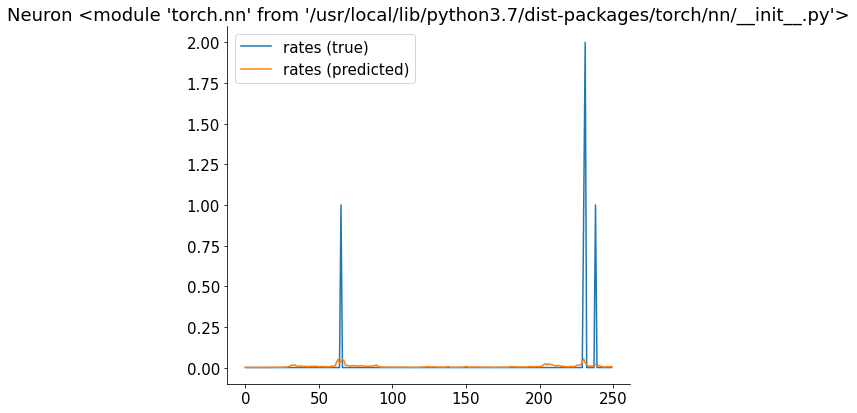

In [62]:
def plot_prediction_vs_data(neuron_id=0, trial_id=29):
  rpred = z.detach().cpu().numpy()
  x0_rates = x0.detach().cpu().numpy()

  plt.figure(figsize=(10, 6))
  plt.plot(x0_rates[:,trial_id, neuron_id])
  plt.plot(rpred[:,trial_id, neuron_id])
  # plt.plot(-.5 + x[:, nn, 0]/4) # these are spikes we don't have that

  plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
  plt.title(f'Neuron {nn}')
  plt.show()
plot_prediction_vs_data()